In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import WandbLogger
import wandb

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import lightning as L
from glob import glob

In [3]:
num_workers = 4
batch_size = 64

image_size = 128

latent_dim = 100

In [4]:
paths = glob('../data/hw2/img_align_celeba/*')

In [5]:
train_paths, val_paths = train_test_split(paths, test_size=0.2, random_state=42)

In [6]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [7]:
from dataset import FaceDataset
train_set = FaceDataset(train_paths, transform)
val_set = FaceDataset(val_paths, transform)

In [8]:
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [9]:
device = 'cuda'

In [10]:
real_batch = next(iter(train_loader))

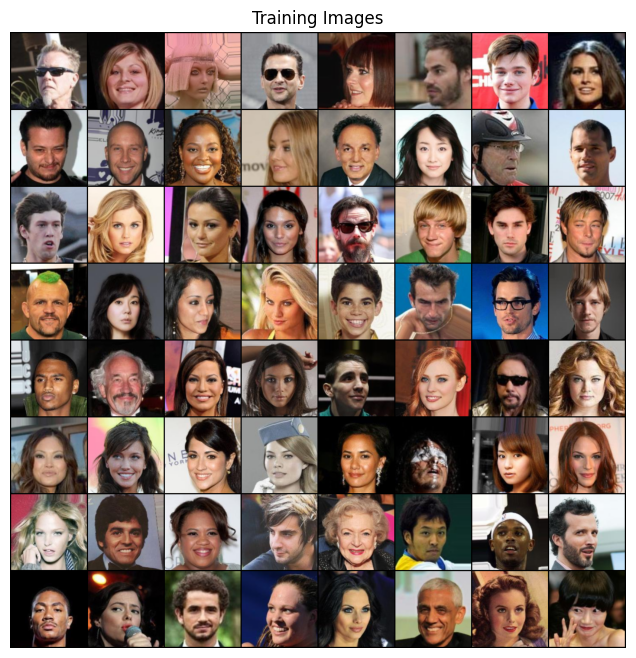

In [11]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

CSPup block

In [13]:
class CSPupBlock(nn.Module):
    def __init__(self, in_channels: int, expansion_method: str = "upsample"):
        super().__init__()
        assert in_channels % 2 == 0, "in_channels must be even"
        
        self.in_channels = in_channels
        self.inner_channels = in_channels // 2
        
        
        # lambda for new initialization of nn.Conv2T
        # ruff wornings makes brrrr
        if expansion_method == 'upsample':
            upsample_init = lambda : nn.Upsample(scale_factor=2)
        elif expansion_method == 'deconv':
            upsample_init = lambda : nn.ConvTranspose2d(
                in_channels=self.inner_channels, 
                out_channels=self.inner_channels, 
                kernel_size=2,
                stride=2,
                bias=True, # True or False better?
                )
        else:
            raise Exception("Unknown expansion method, available: ['upsample', 'deconv']")
        
        # right branch
        self.conv_branch = nn.Sequential(*[
            nn.Conv2d(
                in_channels=self.inner_channels,
                out_channels=self.inner_channels,
                kernel_size=1,
                padding=0,
            ),
            nn.ReLU(inplace=True),
            upsample_init(),
            
            nn.Conv2d(
                in_channels=self.inner_channels,
                out_channels=self.inner_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=self.inner_channels,
                out_channels=self.inner_channels,
                kernel_size=3,
                padding=1,
                ),
        ])
        
        # left branch
        self.upsample_branch = upsample_init()
        self.conv_branch.apply(weights_init)
        
        
    def forward(self, x):
        assert x.shape[1] == self.in_channels
        x1, x2 = torch.split(x, [self.inner_channels, self.inner_channels], dim=1)
        
        return self.upsample_branch(x1) + self.conv_branch(x2)
        

In [14]:
expansion_method = "upsample"

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int = latent_dim, image_size: int = image_size, block_cls = CSPupBlock, expansion_method: str = "upsample"):
        super(Generator, self).__init__()
        self.image_size = image_size
        self.compressed_size = self.image_size // 2 ** 5
        self.latent_dim = latent_dim
        self.l1 = nn.Linear(latent_dim, 1024 * self.compressed_size ** 2)
        self.body = nn.Sequential(*[
            block_cls(1024, expansion_method),
            block_cls(512, expansion_method),
            block_cls(256, expansion_method),
            block_cls(128, expansion_method),
            block_cls(64, expansion_method),
            nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.Tanh(),
        ])
        
    def forward(self, z):
        x = self.l1(z)
        x = x.view(x.shape[0], 1024, self.compressed_size, self.compressed_size)
        x = self.body(x)
        return x

In [16]:
class ConvLReLUBN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False, use_bn=True):
        super(ConvLReLUBN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.2), # new regularization
        )
        self.conv.apply(weights_init)
    def forward(self, x):
        return self.conv(x)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, image_size: int = image_size, hidden: int = 512):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.body = nn.Sequential(
            ConvLReLUBN(3, 64, 3, 2, 1, bias=True, use_bn=False),
            ConvLReLUBN(64, 128, 3, 2, 1),
            ConvLReLUBN(128, 256, 3, 2, 1),
            ConvLReLUBN(256, 512, 3, 2, 1),
            ConvLReLUBN(512, 1024, 3, 2, 1),
        )
        self.head = nn.Sequential(
            nn.Linear(1024 * (self.image_size // 2 ** 5) ** 2, hidden),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.body(x)
        x  = self.head(x.view(x.shape[0], -1))
        return x

In [18]:
real_label = 1.
fake_label = 0.

In [19]:
class DCGAN(L.LightningModule):

    def __init__(self,
                 image_size: int = image_size,
                 latent_dim: int = latent_dim,
                 lr: float = 0.0002,
                 b1: float = 0.5,
                 b2: float = 0.999,
                 batch_size: int = batch_size, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.automatic_optimization = False  # Включаем ручную оптимизацию

        self.generator = Generator(
            latent_dim=self.hparams.latent_dim,
            image_size=self.hparams.image_size,
            block_cls=CSPupBlock,  # Убедитесь, что CSPupBlock определен где-то в вашем коде
            expansion_method="upsample",
            )
        self.discriminator = Discriminator(
            image_size=self.hparams.image_size,
            )

        self.fixed_noise = torch.randn(16, self.hparams.latent_dim)
        self.bce_loss = nn.BCELoss()

    def forward(self, z):
        return self.generator(z)

    def training_step(self, imgs, batch_idx):
        opt_g, opt_d = self.optimizers()

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch

        self.discriminator.zero_grad()
        # Format batch
        real = imgs.to(self.device)
        b_size = real.size(0)
        real_labels = torch.full((b_size, 1), real_label, dtype=torch.float, device=self.device)

        # Forward pass real batch through D
        output_real = self.discriminator(real).view(-1, 1)
        d_loss_real = self.bce_loss(output_real, real_labels)

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, self.hparams.latent_dim, device=self.device)
        # Generate fake image batch with G
        fake = self.generator(noise)
        fake_labels = torch.full((b_size, 1), fake_label, dtype=torch.float, device=self.device)

        # Classify all fake batch with D
        output_fake = self.discriminator(fake.detach()).view(-1, 1)
        # Calculate D's loss on the all-fake batch
        d_loss_fake = self.bce_loss(output_fake, fake_labels)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        d_loss = (d_loss_real + d_loss_fake) / 2
        self.manual_backward(d_loss)
        opt_d.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        self.generator.zero_grad()
        # Labels for generated images are treated as real for generator cost
        g_loss = self.bce_loss(self.discriminator(fake).view(-1, 1), real_labels)
        self.manual_backward(g_loss)
        opt_g.step()

        self.log('g_loss', g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('d_loss', d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        if batch_idx % 300 == 0:
            self.plot()
    
    def plot(self):
        z = self.fixed_noise.to(device)
        sample_imgs = self.generator(z)
        grid = torchvision.utils.make_grid(sample_imgs, nrow=4, normalize=True)
        self.logger.experiment.log(
            {"samples": [wandb.Image(grid, caption="")]},
            step=self.global_step,            
            )
        
    def configure_optimizers(self):
        g_lr = self.hparams.lr
        d_lr = self.hparams.lr * 0.1 # new regularization
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=g_lr, betas=(self.hparams.b1, self.hparams.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=d_lr, betas=(self.hparams.b1, self.hparams.b2))
        return [opt_g, opt_d], []


In [20]:
wandb_logger = WandbLogger(project='deep_gen', save_dir='../logs', version='dcgan_tanh_lr_2', reinit=True)

In [21]:
dcgan = DCGAN()

In [22]:
trainer = L.Trainer(
    max_epochs=50,
    log_every_n_steps=100,
    logger=wandb_logger,
)
trainer.fit(dcgan, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: t-ionov. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 8.3 M 
1 | discriminator | Discriminator | 14.7 M
2 | bce_loss      | BCELoss       | 0     
------------------------------------------------
23.0 M    Trainable params
0         Non-trainable params
23.0 M    Total params
91.821    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/home/ionov/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [24]:
z = torch.randn(64, latent_dim).to(device)

In [25]:
generated_images = dcgan(z)

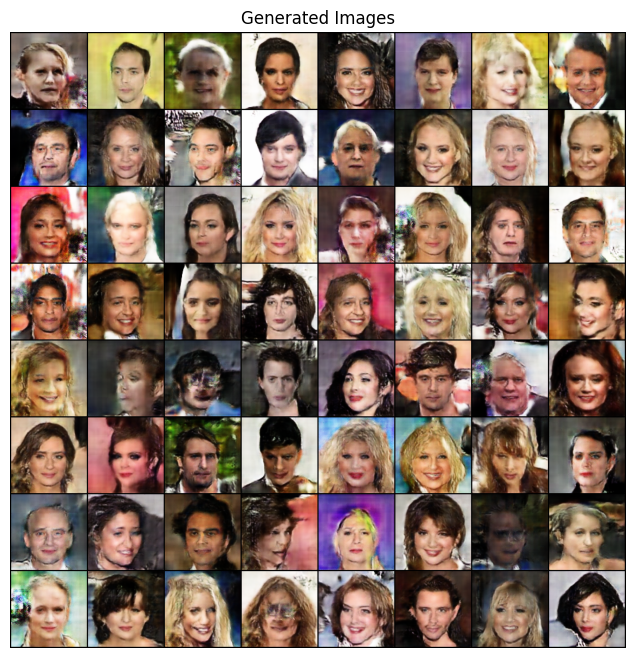

In [30]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()